# Factorization Machine 실습코드

Factorization Machine이 어떻게 이뤄지는지 실제 실습 코드를 바탕으로 구체적으로 이해해보려고 한다.

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
ratings = pd.read_csv('./ratings.csv')

간단한 실습을 위해, movie-lens 가장 최신의 100k를 활용해보고자 한다.

## 이해를 위한 밑바닥부터 만드는 방법

https://yamalab.tistory.com/128 의 내용을 실습해보았다.
 
방정식을 그대로 만들어 가보자.

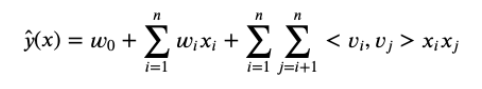

문제는, 세 번째 항을 보면 inference 시에 O(n^2)이 되어버린다. 이 때문에 계산 복잡도를 줄여줘야 한다.

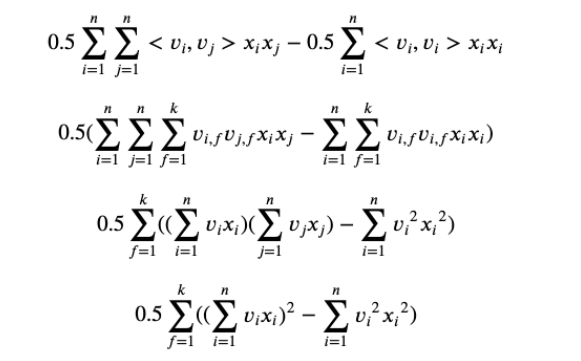

In [7]:
def inference(data):
    num_data = len(data)
    scores = np.zeros(num_data)
    for i in range(num_data):
        feature_idx = data[i][0]
        val = np.array(data[i][1])
        
        # linear feature
        linear_feature_score = np.sum(w[feature_idx] * val)
        
        # factorized feature score
        vx = v[feature_idx] * (val.reshape(-1, 1))
        cross_sum = np.sum(vx, axis = 0)
        square_sum = np.sum(vx*vx, axis = 0)
        cross_feature_score = 0.5*np.sum(np.square(cross_sum) - square_sum)
        
        # model_score for n
        scores[i] = b + linear_feature_score + cross_feature_score
        
    scores = 1 / (1 + np.exp(-scores))
    return scores

In [10]:

# Pre-trained parameters
b = 0.5
w = np.array([0.1, 0.2, -0.3, -0.2])
v = np.array([[0.15, 0.25, 0.15, 0.24],
              [0.13, 0.22, 0.27, 0.31], 
              [0.46, 0.05, 0.22, 0.19], 
              [0.15, 0.22, 0.03, 0.38]])

# Inference test for 3 case
data = [[[0, 1, 3], # feature index 
         [0.33, 1, 1]], # feature value
        [[2],
         [1]],
        [[0, 1, 2, 3],
         [0.96, 1, 1, 1]]]

inference(data)


array([0.6998236 , 0.549834  , 0.79240639])

## Example. Pytorch를 활용하는 방법

In [3]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Pytorch 활용을 위해서는 custom dataset을 만드는 것이 필요할 것이다.
10만개 정도의 데이터 셋 중 80%는 train set, 10%는 valid set, 10%는 test set으로 활용한다.

In [4]:
class MovieLens100kDataset(torch.utils.data.Dataset):
    def __init__(self):
        data = ratings.to_numpy()[:,:3]
        self.items = data[:,:2]
        self.targets = data[:,2]
        self.field_dims = np.max(self.items, axis = 0)+1
        self.user_field_idx = np.array((0,), dtype = np.long)
        self.item_field_idx = np.array((1,), dtype = np.long)
    
    def __len__(self):
        return self.targets.shape[0]
    
    def __getitem__(self, index):
        return self.items[index], self.targets[index]

In [5]:
dataset = MovieLens100kDataset()
train_len = int(len(dataset) * 0.8)
valid_len = int(len(dataset) * 0.1)
test_len = len(dataset) - train_len - valid_len
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, (train_len, valid_len, test_len))

<ipython-input-4-c1bf7a28f884>:7: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.user_field_idx = np.array((0,), dtype = np.long)
<ipython-input-4-c1bf7a28f884>:8: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for w

In [6]:
from torch.utils.data import DataLoader

In [7]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size = batch_size)
valid_loader = DataLoader(valid_set, batch_size = batch_size)
test_loader = DataLoader(test_set, batch_size = batch_size)

### Model 구현

model 구현은 다음을 바탕으로 진행한다.
https://github.com/rixwew/pytorch-fm

In [21]:
class FeaturesLinear(torch.nn.Module):
    def __init__(self, field_dims, output_dim = 1):
        super().__init__()
        # 입력 차원 임베딩.
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        # 출력시의 편향 학습
        self.bias = torch.nn.Parameter(torch.zeros(output_dim,))
        # offset의, 역할은 무엇인가?
        # cumsum은 누적합을 의미한다.
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype = np.long)
        
    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim = 1) + self.bias

In [22]:
class FeaturesEmbedding(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype = np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)
    
    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

In [23]:
class FactorizationMachine(torch.nn.Module):
    def __init__(self, reduce_sum = True):
        super().__init__()
        self.reduce_sum = reduce_sum
        
    def forward(self, x):
        square_of_sum = torch.sum(x, dim = 1) ** 2
        sum_of_square = torch.sum(x ** 2, dim = 1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim = 1, keepim = True)
        return 0.5 * ix

In [24]:
class FactorizationMachineModel(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizaionMachine(reduce_sum = True)
        
    def forward(self, x):
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

In [ ]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

In [ ]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return roc_auc_score(targets, predicts)


In [ ]:
model = get_model(model_name, dataset)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopper = EarlyStopper(num_trials=2, save_path=f'{save_dir}/{model_name}.pt')
    for epoch_i in range(epoch):
        train(model, optimizer, train_data_loader, criterion, device)
        auc = test(model, valid_data_loader, device)
        print('epoch:', epoch_i, 'validation: auc:', auc)
        if not early_stopper.is_continuable(model, auc):
            print(f'validation: best auc: {early_stopper.best_accuracy}')
            break
    auc = test(model, test_data_loader, device)
    print(f'test auc: {auc}')

## Other. FastFM을 활용하는 방법

fm의 경우는 더 간단하게 사용할 수 있으나, 윈도우에서는 불가능하다. 
이미 구현이 되어있다..

## 더 나아가는 방법
Factorization Machine 이상의 방법론에 대해 생각해 볼 수 있을것이다.
DeepFM 등의 방법론도 존재하고, Factorization Machine을 개선한 모델에 대해서는 차차 알아가고자 한다.

추가로, xlearn 등의 패키지도 사용할 수 있겠으나 패키지 사용 보다는 이 자체의 이해를 위해 생략한다.